In [1]:
import os
import warnings
from typing import Any, Dict, List, Tuple

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmeta.datasets.helpers import omniglot
from torchmeta.utils.data import BatchMetaDataLoader
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [2]:
def get_dataloader(
    config: Dict[str, Any]
) -> Tuple[BatchMetaDataLoader, BatchMetaDataLoader, BatchMetaDataLoader]:
    train_dataset = omniglot(
        folder=config["folder_name"],
        shots=config["num_shots"],
        # test_shots=1, # default = shots
        ways=config["num_ways"],
        shuffle=True,
        meta_train=True,
        download=config["download"],
    )
    train_dataloader = BatchMetaDataLoader(
        train_dataset, batch_size=config["task_batch_size"], shuffle=True, num_workers=1
    )

    val_dataset = omniglot(
        folder=config["folder_name"],
        shots=config["num_shots"],
        # test_shots=1, # default = shots
        ways=config["num_ways"],
        shuffle=True,
        meta_val=True,
        download=config["download"],
    )
    val_dataloader = BatchMetaDataLoader(
        val_dataset, batch_size=config["task_batch_size"], shuffle=True, num_workers=1
    )

    test_dataset = omniglot(
        folder=config["folder_name"],
        shots=config["num_shots"],
        # test_shots=1, # default = shots
        ways=config["num_ways"],
        shuffle=True,
        meta_test=True,
        download=config["download"],
    )
    test_dataloader = BatchMetaDataLoader(
        test_dataset, batch_size=config["task_batch_size"], shuffle=True, num_workers=1
    )
    return train_dataloader, val_dataloader, test_dataloader

In [3]:
class MatchingNet(nn.Module):
    def __init__(self, in_channels: int, num_ways: int, num_shots: int) -> None:
        super(MatchingNet, self).__init__()
        self.in_channels = in_channels
        self.emb_size = 64
        self.conv_hidden = 64
        self.num_ways = num_ways
        self.num_support = num_ways * num_shots

        self.cnn = nn.Sequential(
            self.convBlock(self.in_channels, self.emb_size, 3),  # 14
            self.convBlock(self.emb_size, self.emb_size, 3),  # 7
            self.convBlock(self.emb_size, self.emb_size, 3),  # 3
            self.convBlock(self.emb_size, self.emb_size, 3),  # 1
            nn.Flatten(start_dim=1),
            nn.Linear(self.emb_size, self.emb_size),
        )
        self.bilstm = nn.LSTM(
            input_size=self.emb_size,
            num_layers=self.num_support,
            hidden_size=self.emb_size,
            bidirectional=True,
            batch_first=True,
        )

        self.lstm_cell = nn.LSTMCell(
            input_size=self.emb_size, hidden_size=self.emb_size
        )

    @classmethod
    def convBlock(
        cls, in_channels: int, out_channels: int, kernel_size: int
    ) -> nn.Sequential:
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=1),
            nn.BatchNorm2d(out_channels, momentum=1.0, track_running_stats=False),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

    def g(self, support_x: torch.Tensor) -> torch.Tensor:
        batch_size = support_x.shape[0]
        support_cnn = self.cnn(support_x.flatten(start_dim=0, end_dim=1)).unflatten(
            dim=0, sizes=[batch_size, self.num_support]
        )
        support_bilstm, _ = self.bilstm(support_cnn)
        support_bilstm_for, support_bilstm_rev = torch.tensor_split(
            support_bilstm, 2, dim=-1
        )
        return support_bilstm_for + support_bilstm_rev + support_cnn

    def read_out(self, hidden: torch.Tensor, support_emb: torch.Tensor) -> torch.Tensor:
        num_query = int(hidden.shape[0] / support_emb.shape[0])
        support_emb_repeat = support_emb.repeat(
            num_query, 1, 1
        )  # batch_size * num_query, num_support, emb_size
        hidden_T = hidden.unsqueeze(-1)  # batch_size * num_query, emb_size, 1

        attention = F.softmax(
            torch.bmm(support_emb_repeat, hidden_T)
        )  # batch_size * num_query, num_support, 1
        support_emb_att = (
            support_emb_repeat * attention
        )  # batch_size * num_query, num_support, emb_size
        return support_emb_att.sum(1)  # batch_size * num_query, emb_size

    def f(self, query_x: torch.Tensor, support_emb: torch.Tensor) -> torch.Tensor:
        query_cnn = self.cnn(query_x.flatten(start_dim=0, end_dim=1))
        hidden_state = query_cnn.new_zeros(query_cnn.shape)
        read_out = query_cnn.new_zeros(query_cnn.shape)
        cell_state = query_cnn.new_zeros(query_cnn.shape)

        for _ in range(10):
            hidden_state, cell_state = self.lstm_cell(
                query_cnn, (hidden_state + read_out, cell_state)
            )
            hidden_state = hidden_state + query_cnn
            read_out = self.read_out(hidden_state, support_emb)

        query_emb = hidden_state.unflatten(
            dim=0, sizes=[query_x.shape[0], query_x.shape[1]]
        )
        return query_emb

    def forward(
        self, support_x: torch.Tensor, query_x: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        support_emb = self.g(support_x)  # batch_size, num_support, emb_size
        query_emb = self.f(query_x, support_emb)  # batch_size, num_query, emb_size
        return support_emb, query_emb

In [4]:
def get_probability(
    support_emb: torch.Tensor, query_emb: torch.Tensor, support_y, num_ways: int
) -> torch.Tensor:
    batch_size = support_emb.shape[0]
    num_support = support_emb.shape[1]
    num_query = query_emb.shape[1]

    query_emb_repeat = query_emb.unsqueeze(2).repeat(
        1, 1, num_support, 1
    )  # batch_size, num_query, num_support, emb_size
    support_emb_repeat = support_emb.unsqueeze(1).repeat(
        1, num_query, 1, 1
    )  # batch_size, num_query, num_support, emb_size

    similarity = F.cosine_similarity(
        support_emb_repeat, query_emb_repeat, dim=-1, eps=1e-8
    )  # batch_size, num_query, num_support
    attention = F.softmax(similarity, dim=-1)  # batch_size, num_query, num_support
    indices = support_y.unsqueeze(1).expand(
        -1, num_query, -1
    )  # batch_size, num_query, num_support

    prob = attention.new_zeros((batch_size, num_query, num_ways))
    prob.scatter_add_(-1, indices, attention)  # batch_size, num_query, num_ways
    return prob

In [5]:
def train_matching(
    num_ways: int,
    device: str,
    task_batch: Dict[str, List[torch.Tensor]],
    model: MatchingNet,
    criterion: nn.CrossEntropyLoss,
    optimizer: torch.optim.Adam,
) -> Tuple[float, float]:
    model.train()

    support_xs = task_batch["train"][0].to(device=device)
    support_ys = task_batch["train"][1].to(device=device)
    query_xs = task_batch["test"][0].to(device=device)
    query_ys = task_batch["test"][1].to(device=device)

    accuracy = torch.tensor(0.0, device=device)

    support_emb, query_emb = model(support_xs, query_xs)
    query_prob = get_probability(support_emb, query_emb, support_ys, num_ways)

    query_prob_flat = query_prob.flatten(start_dim=0, end_dim=1)
    query_ys_flat = query_ys.flatten()
    loss = criterion(query_prob_flat, query_ys_flat)

    model.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        _, query_pred = torch.max(query_prob, dim=-1)
        accuracy = torch.mean(query_pred.eq(query_ys).float())
    return accuracy.item(), loss.item()

In [11]:
def test_matching(
    num_ways: int,
    device: str,
    task_batch: Dict[str, List[torch.Tensor]],
    model: MatchingNet,
    criterion: nn.CrossEntropyLoss,
) -> Tuple[float, float]:
    model.eval()

    support_xs = task_batch["train"][0].to(device=device)
    support_ys = task_batch["train"][1].to(device=device)
    query_xs = task_batch["test"][0].to(device=device)
    query_ys = task_batch["test"][1].to(device=device)

    accuracy = torch.tensor(0.0, device=device)

    support_emb, query_emb = model(support_xs, query_xs)
    query_prob = get_probability(support_emb, query_emb, support_ys, num_ways)

    query_prob_flat = query_prob.flatten(start_dim=0, end_dim=1)
    query_ys_flat = query_ys.flatten()
    loss = criterion(query_prob_flat, query_ys_flat)

    with torch.no_grad():
        _, query_pred = torch.max(query_prob, dim=-1)
        accuracy = torch.mean(query_pred.eq(query_ys).float())
    return accuracy.item(), loss.item()

In [7]:
def save_model(output_folder: str, model: MatchingNet, title: str) -> None:
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)
    filename = os.path.join(output_folder, title)

    with open(filename, "wb") as f:
        state_dict = model.state_dict()
        torch.save(state_dict, f)
    print("Model is saved in", filename)


def load_model(output_folder: str, model: MatchingNet, title: str) -> None:
    filename = os.path.join(output_folder, title)
    model.load_state_dict(torch.load(filename))
    print("Model is loaded")

In [8]:
def print_graph(
    train_accuracies: List[float],
    val_accuracies: List[float],
    train_losses: List[float],
    val_losses: List[float],
) -> None:
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    axs[0].plot(train_accuracies, label="train_acc")
    axs[0].plot(val_accuracies, label="test_acc")
    axs[0].set_title("Accuracy")
    axs[0].legend()

    axs[1].plot(train_losses, label="train_loss")
    axs[1].plot(val_losses, label="test_loss")
    axs[1].set_title("Loss")
    axs[1].legend()

    fig.show()

In [9]:
config = {
    "folder_name": "dataset",
    "download": True,
    "num_shots": 5,
    "num_ways": 5,
    "output_folder": "saved_model",
    "task_batch_size": 32,  # 필수
    "num_task_batch_train": 600,  # 필수
    "num_task_batch_test": 200,  # 필수
    "device": "cuda",  # 필수
}

train_dataloader, val_dataloader, test_dataloader = get_dataloader(config)

model = MatchingNet(
    in_channels=1, num_ways=config["num_ways"], num_shots=config["num_shots"]
).to(device=config["device"])

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

  0%|          | 0/9464212 [00:00<?, ?it/s]

  0%|          | 0/6462886 [00:00<?, ?it/s]

100%|██████████| 600/600 [03:44<00:00,  2.67it/s, train_accuracy=0.9712, train_loss=1.4501, val_accuracy=0.9712, val_loss=1.4501]


Model is saved in saved_model/matching_network.th


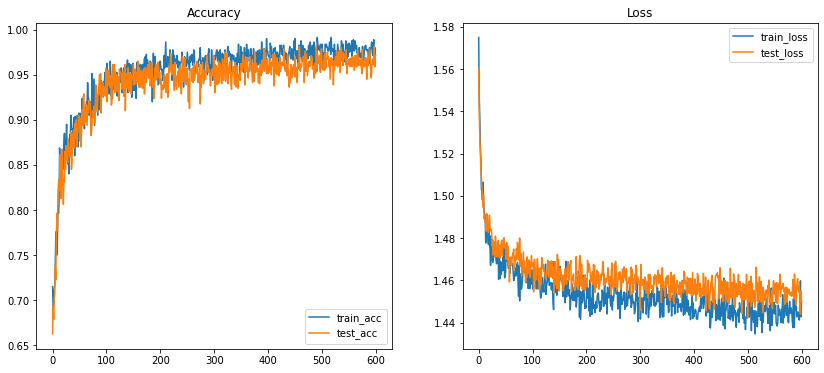

In [12]:
# 메타-트레이닝
with tqdm(
    zip(train_dataloader, val_dataloader), total=config["num_task_batch_train"]
) as pbar:
    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []

    for task_batch_idx, (train_batch, val_batch) in enumerate(pbar):
        if task_batch_idx >= config["num_task_batch_train"]:
            break

        train_accuracy, train_loss = train_matching(
            num_ways=config["num_ways"],
            device=config["device"],
            task_batch=train_batch,
            model=model,
            criterion=criterion,
            optimizer=optimizer,
        )
        val_accuracy, val_loss = test_matching(
            num_ways=config["num_ways"],
            device=config["device"],
            task_batch=val_batch,
            model=model,
            criterion=criterion,
        )

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        pbar.set_postfix(
            train_accuracy="{0:.4f}".format(train_accuracy),
            val_accuracy="{0:.4f}".format(val_accuracy),
            train_loss="{0:.4f}".format(train_loss),
            val_loss="{0:.4f}".format(val_loss),
        )

    # 모델 저장하기
    save_model(
        output_folder=config["output_folder"], model=model, title="matching_network.th"
    )

    print_graph(
        train_accuracies=train_accuracies,
        val_accuracies=val_accuracies,
        train_losses=train_losses,
        val_losses=val_losses,
    )

In [13]:
# 모델 불러오기
load_model(
    output_folder=config["output_folder"], model=model, title="matching_network.th"
)

# 메타-테스팅
with tqdm(test_dataloader, total=config["num_task_batch_test"]) as pbar:
    sum_test_accuracies = 0.0
    sum_test_losses = 0.0

    for task_batch_idx, test_batch in enumerate(pbar):
        if task_batch_idx >= config["num_task_batch_test"]:
            break

        test_accuracy, test_loss = test_matching(
            num_ways=config["num_ways"],
            device=config["device"],
            task_batch=test_batch,
            model=model,
            criterion=criterion,
        )

        sum_test_accuracies += test_accuracy
        sum_test_losses += test_loss
        pbar.set_postfix(
            test_accuracy="{0:.4f}".format(sum_test_accuracies / (task_batch_idx + 1)),
            test_loss="{0:.4f}".format(sum_test_losses / (task_batch_idx + 1)),
        )

Model is loaded


100%|██████████| 200/200 [01:13<00:00,  2.72it/s, test_accuracy=0.9602, test_loss=1.4563]
